## Same as SkyBackground_FilterWidths, ...

but using filter transmission curves to calculate the sky background within some filter.

From Iridian:

>Also in the meeting we discussed "how narrow a filter we can offer and the angular sensitivity of this".  I have attached here some pdf slides on a "sub-nm " BPF demo that we have coated along with an excel file describing the effects of cone angle.  The narrowest filter that we can grow depends on the uniformity that can be achieved over the desired clear aperture.   One way to think about this is that there is an effective clear aperture outside of which the filter shifts by more than its bandwidth.  If the effective clear aperture < specified clear aperture, then the bandwidth is too narrow for the attainable uniformity.

>For a 0.04% total uniformity variation over a clear aperture of 150 mm, then the minimum bandwidth is CWL * uniformity.  For CWL=659 nm, the min bandwidth =  0.27 nm.   In practice, we'd probably want to limit a CWL shift due to uniformity to ½ the bandwidth (in order to still have the line of interest being transmitted) --> min FWHM = 0.54 nm for CWL = 659 nm.

>Adam has calculated the transmittance of three different FWHM filters (and the results are in the attached excel file) : <br>
a)	CWL=659 nm, FWHM = 3.1 nm,  Collimated, CHA = 1.5° and 11°  for AOI=0° and 10°  <br>
b)	CWL= 659 nm, FWHM = 0.8 nm, Collimated, CHA = 1.5° and 11°  for AOI=0° and 10°  <br>
c)	CWL= 659 nm, FWHM = 0.4 nm, Collimated, CHA = 1.5° and 11°  for AOI=0° and 10°  <br>

>As you can see, all of these calculations assume a flat profile with angle (worst case).  Adam did one calculation for a Gaussian profile - this is also in the excel file.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from astropy.io import fits

In [2]:
def loadBackgroundGemini(start,end,machine,plot=False,verbose=False):
    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    if machine=='chinook':
        geminiloc='/Users/lokhorst/Documents/Eagle/Gemini_skybackground.dat'
    elif machine=='coho':
        geminiloc='/Users/deblokhorst/Documents/Dragonfly/HalphaScripts/Gemini_skybackground.dat'
    
    with open(geminiloc,'r') as f:  #wavelength in nm, flux in phot/s/nm/arcsec^2/m^2
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                wavelength.append(tmp[0])
                flux.append(tmp[1])
                
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
        
    return wavelength[start_ind-1:end_ind+1],flux[start_ind-1:end_ind+1]

In [3]:
def loadBackgroundUVES(start,end,machine,plot=False,verbose=False):
    
    #start = start*10
    #end = end*10
    
    def getUVESBackground(filename):
        hdulist = fits.open(filename)
        flux = hdulist[0].data
    
        CRPIX1 = hdulist[0].header['CRPIX1']
        CRVAL1 = hdulist[0].header['CRVAL1']
        CDELT1 = hdulist[0].header['CDELT1']
        #print(CRPIX1,CRVAL1,CDELT1)
        hdulist.close()
        
        begin = CRVAL1 - CRPIX1*CDELT1   
        end = begin + len(flux)*CDELT1
        wavelength = np.arange(begin,end,CDELT1)
        #print(len(wavelength),len(flux))
        return wavelength,flux

    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    filename1 = "fluxed_sky_580U.fits"
    filename2 = "fluxed_sky_860L.fits"
    leakycolumns = [6340.5, 6407, 6475.5,6545, 6616, 6689,6763] # locations where should mask data
    # about 2 angstrom thick
    

    if machine=='coho':
        uvesloc = '/Users/deblokhorst/Dropbox/UVES_Sky_Background/UVES_sky_all/'
    elif machine =='chinook':
        uvesloc = '/Users/lokhorst/Dropbox/UVES_Sky_Background/UVES_sky_all/'
    else:
        print 'No machine specified!'
    
    wavelength_UVES1,flux_UVES1=getUVESBackground(uvesloc+filename1)
    wavelength_UVES2,flux_UVES2=getUVESBackground(uvesloc+filename2)

    if len(wavelength_UVES2)==(len(flux_UVES2)+1):
        if verbose:
            print('wavelength array is one element longer than the flux array.  Shortening the wavelength array.')
        wavelength_UVES2 = wavelength_UVES2[0:-1]
        
    wavelength = np.append(wavelength_UVES1[wavelength_UVES1<6700.],wavelength_UVES2[wavelength_UVES2>6700.])
    flux = np.append(flux_UVES1[wavelength_UVES1<6700.],flux_UVES2[wavelength_UVES2>6700.])
        
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    # convert the units to nm and ph / s / nm / m**2 / arcsec**2
    wavelength = wavelength / 10.  
        # Angs --> nm
    flux = flux *10**-16 * ((wavelength*10**-9)/(const.h.to('erg s').value * const.c.to('m/s').value)) * 10. * (100/1)**2 
        # (erg --> photon) and (/ Ang --> / nm) and (/ cm**2 --> / m**2)
        
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
    
    return wavelength[start_ind-1:end_ind+1],flux[start_ind-1:end_ind+1]

In [4]:
def getFluxFlatFilter(wavelength,flux,start,end):
    start_ind = 1
    end_ind = len(wavelength)-2
    # if spacings are not even, need to add element by element
    total=0
    for index in np.arange(start_ind,end_ind):
        total = total+(flux[index]*(wavelength[index+1]-wavelength[index]))
        
    # slight better
    fluxarray = flux[start_ind:end_ind]
    wavelenarray_left = wavelength[start_ind-1:end_ind-1]
    wavelenarray_cent = wavelength[start_ind:end_ind]
    wavelenarray_righ = wavelength[start_ind+1:end_ind+1]
    total3 = np.sum(fluxarray*(wavelenarray_righ-wavelenarray_left))/2.
           
    actualwavelenrange = np.mean([wavelenarray_cent[-1],wavelenarray_righ[-1]]) - \
                        np.mean([wavelenarray_left[0],wavelenarray_cent[0]])
    if verbose:
        print actualwavelenrange
        print end-start
        
    # scaling to match desired wavelength range, since resolution might not match up correctly
    total4 = total3 * (end-start)/actualwavelenrange
    
    if verbose:
        print 'COMPARE: %s and %s and %s'%(total,total3,total4)
        
    if plot==True:
        plt.plot(wavelength[start_ind-100:end_ind+100],flux[start_ind-100:end_ind+100])
        top = max(flux[start_ind-100:end_ind+100])
        plt.plot([start,start,end,end,start],[0,top,top,0,0])
        plt.show()
        
    return total4

In [5]:
filterdict = {}

def loadFilter(thisfilter,wavefront='Collimated'):
    """Load the Iridian Transmission curves from the data files for different bandpass filters (BPF).
    
       thisfilter:  specify which Iridian filter to load
                       Options: '6599_3nm_0deg','6599_3nm_10deg','6599_08nm_0deg','6599_08nm_10deg',
                                 '6599_08nm_10deg_Gaus','6599_04nm_0deg','6599_04nm_10deg'
       
       wavefront:  specify which wavefront type for the transmission curve
                       Options:  Collimated, ConeAngle22deg, ConeAngle3deg
    """
    # filter options
    filters = ['6599_3nm_0deg','6599_3nm_10deg','6599_08nm_0deg','6599_08nm_10deg',\
               '6599_08nm_10deg_Gaus','6599_04nm_0deg','6599_04nm_10deg']
    
    if thisfilter not in filters:
        print "WARNING: Filter specified not in list of options.  Using default filter."
        thisfilter = filters[0]
        
    # check if already loaded into dictionary first
    if thisfilter in filterdict:
        data = filterdict[thisfilter]
        return data['wavelen1'],data[wavefront]
    else:
        # load filter data from Iridian files
        data = np.genfromtxt('%s.dat'%thisfilter,  dtype='f', \
                             names=('wavelen1', 'Collimated', 'wavelen2', 'ConeAngle22deg', 'wavelen3','ConeAngle3deg'))
        # save into dictionary
        filterdict[thisfilter] = data

        return data['wavelen1'],data[wavefront]

def getFlux(thisfilter,thissky = 'Gemini',machine='coho'):
    """Integrate over the filter and sky background spectrum.
    
        thisfilter:  specify which Iridian filter to load
        
        thissky: specify which sky background to use to integrate over and get total sky flux
                    Options: Gemini, UVES
        
        machine: specify which machine you are running the code on (for locations of data)
                    Options: chinook, coho
    """
    # load data
    if thissky == 'Gemini':
        dwavelength, dflux = loadBackgroundGemini(640.,680.,machine)
    elif thissky =='UVES':
        dwavelength, dflux = loadBackgroundUVES(640.,680.,machine)
    else:
        print "WARNING: Filter not recognized. Please choose either Gemini or UVES. Returning None."
        return None
    
    # load transmission curve
    twavelength, tflux = loadFilter(thisfilter) #transmission curve of the filter
    
    # reinterpolate transmission onto the same wavelength def as the data
    itflux = np.interp(dwavelength, twavelength, tflux, left=0., right=0.)  
            ## left and right are the values for tflux for dwavelength outside range of twavelength
        
    # if the filter is null on that wavelength range flux is then 0
    ind = itflux > 0.  # makes a masked array where True if >0 and False if <=0
    
    if True in ind:
        # limit integrals to where necessary
        # ind = itflux > 0.
        total = np.trapz( itflux[ind] * dflux[ind], dwavelength[ind], axis=-1)
        if np.isinf(total).any():
            print("WARNING: inf value from integration.")
        return total
    else:
        return 0.


# to dos

- test loading the filter transmission curves
- plot the filter transmission curves with the sky spectra
- confirm that the units work out for the integral of the flux calculation


In [10]:
machine = 'chinook'

In [19]:
twavelength, tflux = loadFilter('6599_3nm_0deg')
dwavelength, dflux = loadBackgroundGemini(640.,680.,machine)
dwavelength_u, dflux_u = loadBackgroundUVES(640.,680.,machine)

In [23]:
itflux = np.interp(dwavelength, twavelength, tflux, left=0., right=0.)

(0, 1.5)

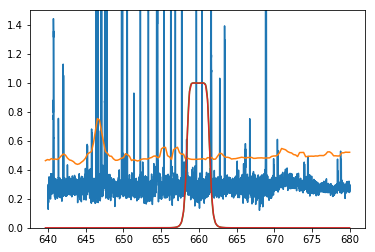

In [24]:
plt.plot(dwavelength_u,dflux_u)
plt.plot(dwavelength,dflux)
plt.plot(twavelength,tflux)
plt.plot(dwavelength,itflux)
plt.ylim(0,1.5)

In [27]:
ind = itflux > 0.

In [30]:
total = np.trapz( itflux[ind] * dflux[ind], dwavelength[ind], axis=-1)

In [31]:
print total

1.5044920901
